In [84]:
import pandas as pd
import os
import numpy as np
import time
import h5py
import librosa
import mido
import matplotlib.pyplot as plt
import pygame

In [85]:
class ProgressBar:
    def __init__(self, total, length=40):
        self.total = total
        self.length = length
        self.current = 0
        self.start_time = time.time()

    def update(self, step=1):
        self.current += step
        progress = self.current / self.total
        filled_length = int(self.length * progress)
        bar = '=' * filled_length + '-' * (self.length - filled_length)
        if self.current == 1 or self.current == self.total or filled_length > int(self.length * ((self.current - step) / self.total)):
            print(
                f'\r|{bar}| {self.current}/{self.total} ({progress:.2%})  {time.time() - self.start_time:.1f}s', end='')

In [86]:
class DatasetGenerator():
    def __init__(
        self,
        wav_mid_df: pd.DataFrame,
        output_path: str,
        chunk_size: int = 128,
        step_size: int = 64,
        sample_rate: int = 12_800,
        n_fft: int = 2048,
        hop_length: int = 256,
        n_mels: int = 512,
        override: bool = False,
    ):
        self.wav_mid_df = wav_mid_df
        self.output_path = output_path
        self.chunk_size = chunk_size
        self.step_size = step_size
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.time_per_frame = hop_length / sample_rate

        if override and os.path.exists(self.output_path):
            os.remove(self.output_path)

    def _get_spectogram(self, wave_path: str) -> np.ndarray:
        samples, sr = librosa.load(wave_path, sr=self.sample_rate)

        mel_spectrogram = librosa.feature.melspectrogram(
            y=samples, sr=sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        return mel_spectrogram_db

    def _get_message_df(self, midi_path) -> pd.DataFrame:
        mid = mido.MidiFile(midi_path)
        note_msg = map(lambda x: (x, x.time), mid.tracks[-1])
        note_df = pd.DataFrame(note_msg, columns=['other', 'time'])

        note_df['time'] = note_df['time'].cumsum()
        note_df = note_df[note_df['other'].apply(
            lambda x: x.type == 'note_on')]
        note_df['note'] = note_df['other'].apply(lambda x: x.note)
        note_df['velocity'] = note_df['other'].apply(lambda x: x.velocity)
        note_df = note_df.drop(columns=['other']).reset_index(drop=True)
        return note_df

    def _get_spec_chunk(self, spec: np.ndarray, i: int) -> np.ndarray:
        spec_chunk = spec[:, i * self.step_size: i *
                          self.step_size + self.chunk_size].copy()
        spec_chunk = (spec_chunk - spec_chunk.min()) / \
            (spec_chunk.max() - spec_chunk.min()) * 255
        spec_chunk = spec_chunk.astype(np.uint8)
        return spec_chunk

    def _get_midi_chunk(self, midi: pd.DataFrame, i: int) -> np.ndarray:
        start_time = i * self.step_size * self.time_per_frame * 1000
        end_time = (i * self.step_size + self.chunk_size) * self.time_per_frame * 1000

        midi_chunk = midi[(midi['time'] >= start_time) &
                          (midi['time'] < end_time)].copy()
        midi_chunk['time'] = midi_chunk['time'] - int(start_time)
        return midi_chunk.to_numpy()

    def _get_chunk_meta(self, midi_chunk: np.ndarray):
        if midi_chunk.shape[0] == 0:
            return np.array([0, 0, 0])
        meta = [midi_chunk[:, 1].min(), midi_chunk[:, 1].max(),
                len(midi_chunk)]
        return meta

    def _get_chunks(self, wave_path: str, midi_path: str) -> pd.DataFrame:
        spec = self._get_spectogram(wave_path)
        midi = self._get_message_df(midi_path)

        length = int((spec.shape[1] - self.chunk_size) / self.step_size)
        chunks = []
        for i in range(length):
            spec_chunk = self._get_spec_chunk(spec, i)
            midi_chunk = self._get_midi_chunk(midi, i)

            chunks.append((spec_chunk, midi_chunk))
        return pd.DataFrame(chunks, columns=['spec', 'midi'])

    def _save_chunk(self, spec_chunk: np.ndarray, midi_chunk: np.ndarray, piece_name: str):
        with h5py.File(self.output_path, 'a') as h5:
            if piece_name not in h5:
                piece_group = h5.create_group(piece_name)
            else:
                piece_group = h5[piece_name]

            chunk_idx = len(piece_group)
            chunk_group = piece_group.create_group(f'chunk_{chunk_idx}')

            chunk_group.create_dataset(
                'image', data=spec_chunk, compression='gzip')
            chunk_group.create_dataset(
                'midi', data=midi_chunk, compression='gzip')
            chunk_group.create_dataset(
                'meta', data=self._get_chunk_meta(midi_chunk), compression='gzip')

    def generate(self):
        output_dir = os.path.dirname(self.output_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)

        progress_bar = ProgressBar(len(self.wav_mid_df))
        for i, (idx, row) in enumerate(self.wav_mid_df.iterrows()):
            wave_path = row['wav']
            midi_path = row['midi']
            piece_name = os.path.basename(wave_path).split('.')[0]

            if os.path.exists(wave_path) and os.path.exists(midi_path):
                chunks = self._get_chunks(wave_path, midi_path)
                for _, (spec_chunk, midi_chunk) in chunks.iterrows():
                    self._save_chunk(spec_chunk, midi_chunk, piece_name)
            else:
                print(f"File not found: {wave_path} or {midi_path}")

            progress_bar.update()

    # def _getSimpleSpectogram(self, wave_file: str, notes: list[int]):
    #     spec = self.getSpectogram(wave_file)
    #     mel_frequencies = librosa.mel_frequencies(n_mels=spec.shape[0], fmin=0, fmax=self.sample_rate / 2)

    #     note_freqs = pd.read_csv('note_freqs.csv').values
    #     indexes = np.array([mel_frequencies[np.abs(mel_frequencies - val).argmin()] for val in note_freqs])
    #     indexes = np.array([np.where(mel_frequencies == val)[0][0] for val in indexes])
    #     indexes = indexes[notes]

    #     spec = spec[indexes]
    #     return spec, mel_frequencies[indexes]

In [87]:
pygame.init()
pygame.mixer.init()
pygame.mixer.music.load('waves/1108.wav')
pygame.mixer.music.set_endevent(pygame.USEREVENT)
pygame.mixer.music.play()
pygame.mixer.music.set_volume(2)

# pygame.mixer.music.play()

In [88]:
def get_spec(path):
    samples, sr = librosa.load(f'{path}.wav', sr=12_800)
    mel_spectrogram = librosa.feature.melspectrogram(
        y=samples, sr=sr, n_fft=2048, hop_length=128, n_mels=512)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram_db

def get_midi(path: str) -> pd.DataFrame:
    mid = mido.MidiFile(f'{path}.mid')
    ticks_per_beat = mid.ticks_per_beat

    mid = pd.DataFrame([(msg, msg.time)
                       for msg in mid.tracks[-1]], columns=['other', 'time'])

    mid['time'] = mid['time'] * 500_000 / 1000 / ticks_per_beat
    mid['time'] = mid['time'].cumsum()
    mid['time'] = mid['time'].astype(np.int32)
    mid['time'] //= 10

    mid = mid[mid['other'].apply(lambda x: x.type == 'note_on')]
    mid['note'] = mid['other'].apply(lambda x: x.note)
    mid['velocity'] = mid['other'].apply(lambda x: x.velocity)

    mid = mid.drop(columns=['other']).reset_index(drop=True)
    return mid

def get_pianoroll(mid: pd.DataFrame, spec: np.ndarray) -> np.ndarray:
    pianoroll = np.zeros((128, mid['time'].max() + 1), dtype=np.uint8)
    active_notes = set()
    prev_time = 0

    for i, row in mid.iterrows():
        for j in range(prev_time, row['time']):
            for note in active_notes:
                pianoroll[note, j] = 1
        if row['velocity'] > 0:
            active_notes.add(row['note'])
        else:
            active_notes.discard(row['note'])

        prev_time = row['time']
    padding = np.zeros((128, spec.shape[1] - pianoroll.shape[1]), dtype=np.uint8)
    pianoroll = np.hstack((pianoroll, padding))
    return pianoroll

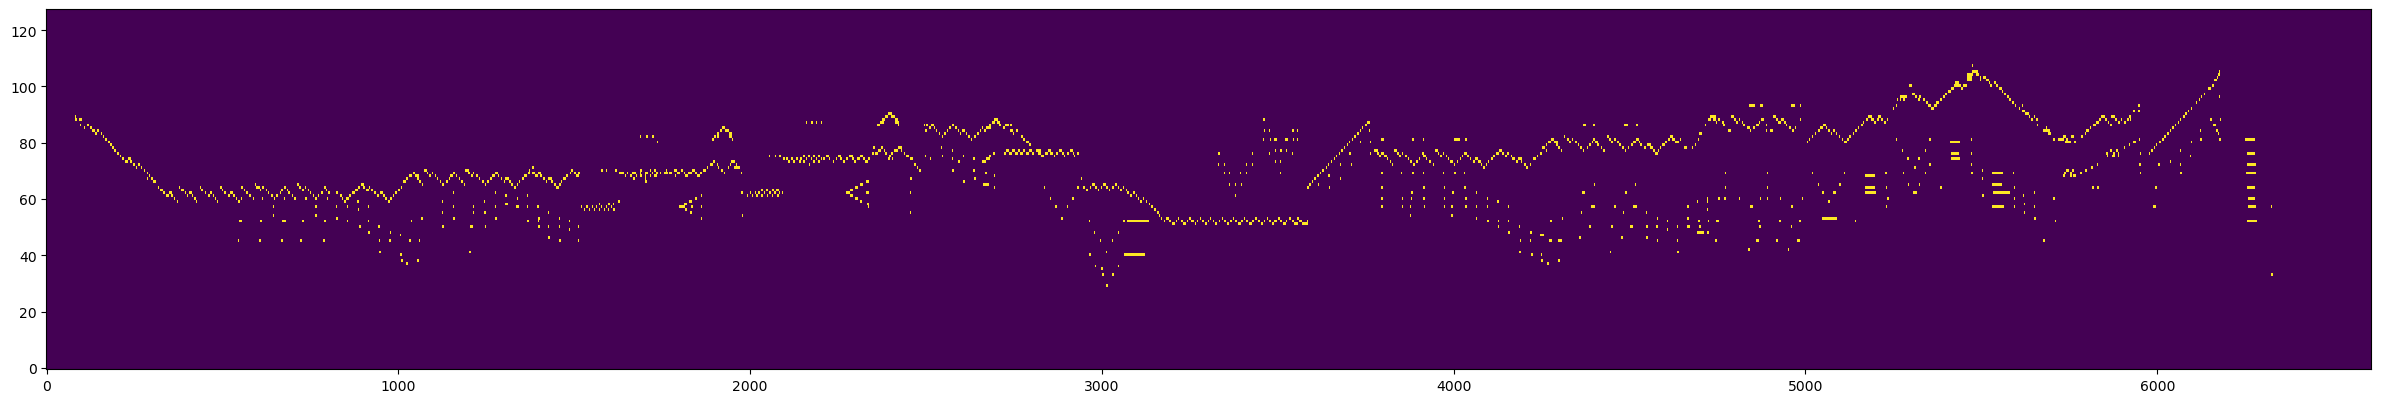

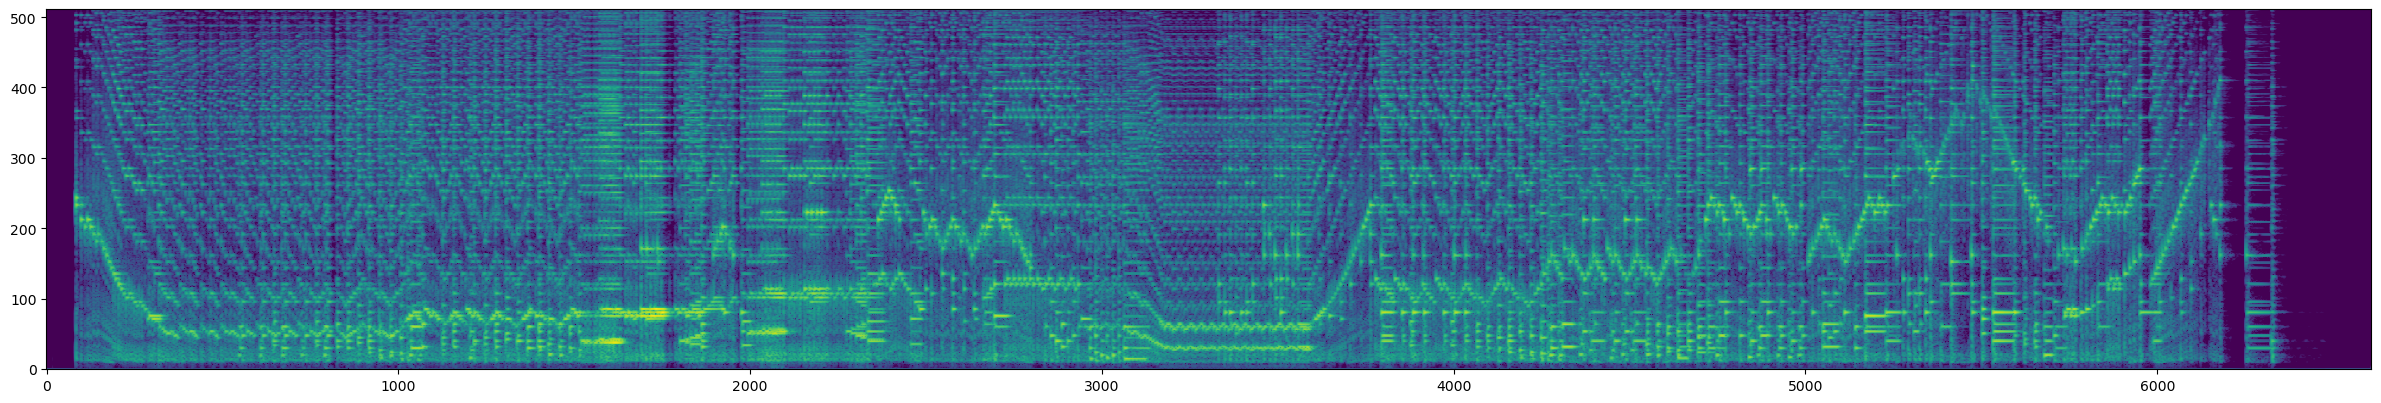

(512, 6609)
(128, 6609)
      time  note  velocity
0       83    88        82
1       83    89        86
2       86    89         0
3       87    88         0
4       93    88        33
...    ...   ...       ...
2617  6284    52         0
2618  6325    57        63
2619  6326    33        55
2620  6328    57         0
2621  6330    33         0

[2622 rows x 3 columns]


In [89]:
for i in [1108]: # [6, 8, 9, 10, 15, 38, 1272, 1271, 1257, 1223]:
    path = f'waves/{i}'
    
    mid = get_midi(path)
    mel_spectrogram_db = get_spec(path)
    pianoroll = get_pianoroll(mid, mel_spectrogram_db)


    plt.figure(figsize=(30, 20))
    plt.imshow(pianoroll[:, :], aspect=8, interpolation='nearest', origin='lower')
    plt.show()

    plt.figure(figsize=(30, 20))
    plt.imshow(mel_spectrogram_db[:, :], aspect=2, interpolation='nearest', origin='lower')
    plt.show()
    print(mel_spectrogram_db.shape)
    print(pianoroll.shape)
    print(mid)

In [90]:
# pygame.mixer.music.stop()

In [91]:
mid = mido.MidiFile('waves/1108.mid')
ticks_per_beat = mid.ticks_per_beat
note_msg = map(lambda x: (x, x.time), mid.tracks[-1])
note_df = pd.DataFrame(note_msg, columns=['other', 'time'])
note_df['time'] *= 500_000 / 1000 / ticks_per_beat
note_df['time'] = note_df['time'].cumsum()
note_df['time'] = note_df['time'].astype(np.int32)
note_df = note_df[note_df['other'].apply(
    lambda x: x.type == 'note_on')]
note_df['note'] = note_df['other'].apply(lambda x: x.note)
note_df['velocity'] = note_df['other'].apply(lambda x: x.velocity)
note_df = note_df.drop(columns=['other']).reset_index(drop=True)
note_df

,time,note,velocity
0,839,88,82
1,839,89,86
2,861,89,0
3,872,88,0
4,930,88,33
...,...,...,...
2617,62847,52,0
2618,63256,57,63
2619,63265,33,55
2620,63286,57,0


In [92]:
samples, sr = librosa.load('waves/1108.wav', sr=12_800)
mel_spectrogram = librosa.feature.melspectrogram(
    y=samples, sr=sr, n_fft=2048, hop_length=128, n_mels=512)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
mel_spectrogram_db.shape

(512, 6609)

In [ ]:
df = pd.read_csv('wav_midi.csv')
df['midi'] = df['midi'].apply(lambda x: f'waves/{x}')
for i, row in df.iterrows():
    mid = mido.MidiFile(row['midi'])
    ticks_per_beat = mid.ticks_per_beat
    for msg in mid:
        if msg.type == 'set_tempo' and msg.tempo != 500_000:
            print(f"Tempo: {msg.tempo}")
            

Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo: 500000
Tempo:

KeyboardInterrupt: 